# P1 - Time Series Analysis

Due date: July 18, 2021, 11:59 pm

- The result will be evaluated from a report in Jupyter, which must be found in a public GitHub repository.
- The project must be carried out in the groups assigned in class.
- Use clear and rigorous procedures.
- Due date: July 18, 2021, 11:59 pm, through Bloque Neón + (Upload repository link)
- Projects will not be received after the delivery time or by any other means than the one established.

The project seeks to analyze a question of interest, which can be framed within a context, in order to interpret the results

1. Choosing your time series (Friday July 11th).

For the project, each group must select a dataset of their choice where the analysis can be performed using a time series model. There are many sources of time series data on the Internet. Government agencies are some of the best sources. But be resourceful. It is better to find a data set is from a process that interests you. Use a recent time-series, also try to avoid a tipical stock-price / exchange rates series. The selected time series must be sent no later than Sunday, July 11, 11:59 pm, through Sicua +, for approval.

The analysis of the data must consider:

2. Analysis of the context of the problem and relevance of the analysis: This should answer the question of why it is interesting or important to study the selected data.

3. Understanding the data: Understand and analyze the main components of the time series, for example: seasonality, cyclicity, autocorrelation, behavior of the residuals, among others. Make use of graphs that allow you to understand each of the components clearly.

4. Application of the models in predictions: Correct use of the models seen in class to make predictions related to the problem of interest.

5. Conclusions: The conclusions must be relevant to the problem of interest. Conclusions on the procedures performed are also expected.

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('../datasets/dataset_proyecto1.zip')

In [7]:
df.head()
df.columns

Index(['date', 'warehouse_id_ref', 'itemid', 'demand', 'pending_demand',
       'lastPrice', 'Price', 'stock', 'available_stock', 'city',
       'CAT_ACCESORIOS', 'CAT_EXPOPET', 'CAT_SNACKS', 'CAT_MEDICINAS',
       'CAT_CUIDADO_E_HIGIENE', 'CAT_JUGUETES', 'CAT_ALIMENTO_PRESCRIPCION',
       'CAT_HIGIENE', 'CAT_REGALOS', 'CAT_PARA_PETLOVERS', 'CAT_FARMAPET',
       'CAT_PREMIOS', 'CAT_VETERINARIOS', 'CAT_ALIMENTO', 'CAT_COMBOS',
       'CAT_ARENAS'],
      dtype='object')

In [15]:
df['ALIMENTOS'] = (df.CAT_SNACKS + df.CAT_ALIMENTO_PRESCRIPCION + df.CAT_ALIMENTO) >= 1
df['ALIMENTOS'] = df.ALIMENTOS.astype('int')
df.head()

,date,warehouse_id_ref,itemid,demand,pending_demand,lastPrice,Price,stock,available_stock,city,...,CAT_HIGIENE,CAT_REGALOS,CAT_PARA_PETLOVERS,CAT_FARMAPET,CAT_PREMIOS,CAT_VETERINARIOS,CAT_ALIMENTO,CAT_COMBOS,CAT_ARENAS,ALIMENTOS
0,2020-08-17T00:00:00.000Z,1,9953,0,0,11560.0,11560.0,3.0,1.0,Bogota,...,0,0,0,1,0,0,0,0,0,0
1,2020-08-18T00:00:00.000Z,1,9953,0,0,11560.0,11560.0,3.0,1.0,Bogota,...,0,0,0,1,0,0,0,0,0,0
2,2020-08-19T00:00:00.000Z,1,9953,2,0,11560.0,11560.0,3.0,1.0,Bogota,...,0,0,0,1,0,0,0,0,0,0
3,2020-08-20T00:00:00.000Z,1,9953,0,0,11560.0,11560.0,3.0,1.0,Bogota,...,0,0,0,1,0,0,0,0,0,0
4,2020-08-21T00:00:00.000Z,1,9953,0,0,11560.0,11560.0,3.0,1.0,Bogota,...,0,0,0,1,0,0,0,0,0,0


In [18]:
df = df[['date', 'warehouse_id_ref', 'itemid', 'demand', 'pending_demand', 
         'lastPrice', 'Price', 'stock', 'available_stock', 'city', 'ALIMENTOS']]

In [19]:
df_alimentos = df[df.ALIMENTOS == 1]
df_no_alimentos = df[df.ALIMENTOS == 0]
print( df.shape ) 
print( df_alimentos.shape ) 
print( df_no_alimentos.shape ) 

(2286885, 11)
(1423388, 11)
(863497, 11)


In [20]:
df_alimentos.head()

,date,warehouse_id_ref,itemid,demand,pending_demand,lastPrice,Price,stock,available_stock,city,ALIMENTOS
330,2020-08-17T00:00:00.000Z,1,10642,0,0,3299.0,3299.0,266.0,1.0,Bogota,1
331,2020-08-18T00:00:00.000Z,1,10642,16,2,3299.0,3299.0,266.0,1.0,Bogota,1
332,2020-08-19T00:00:00.000Z,1,10642,5,0,3299.0,3299.0,266.0,1.0,Bogota,1
333,2020-08-20T00:00:00.000Z,1,10642,20,0,3299.0,3299.0,266.0,1.0,Bogota,1
334,2020-08-21T00:00:00.000Z,1,10642,2,0,3299.0,3299.0,266.0,1.0,Bogota,1


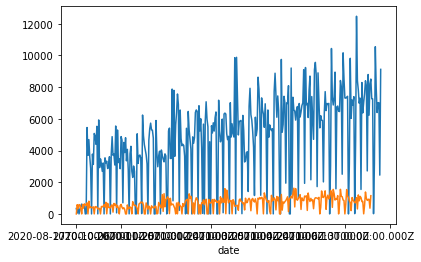

In [24]:
df_alimentos.groupby('date')['demand'].sum().plot()
df_no_alimentos.groupby('date')['demand'].sum().plot()

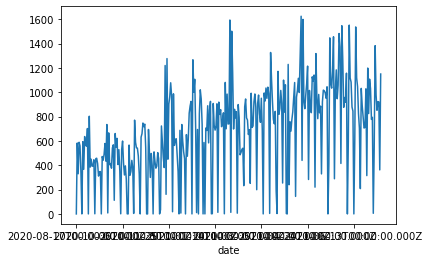

In [25]:
df_no_alimentos.groupby('date')['demand'].sum().plot()